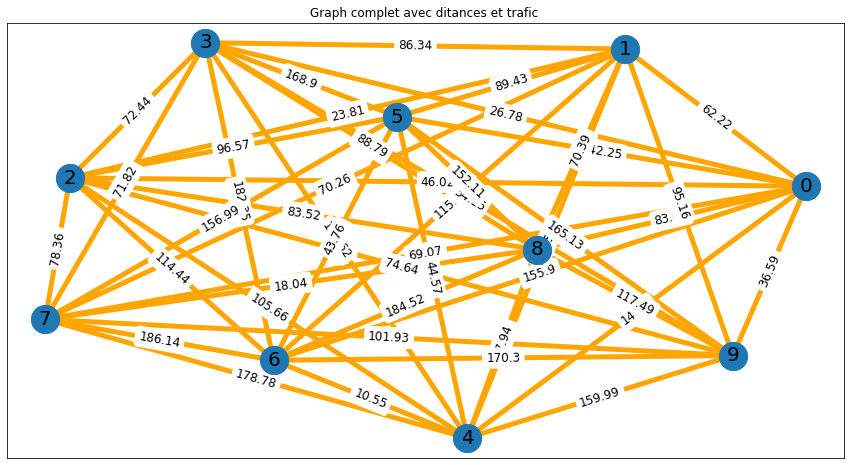

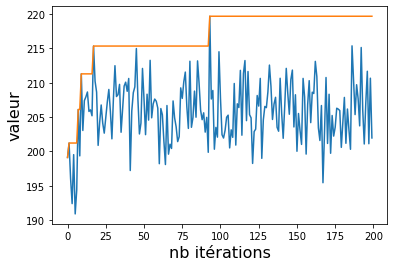

In [62]:
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
from pymongo import MongoClient
import pprint
import datetime
#tabou methode
#step 1 - init graph complete  
#step 2 - tabou list (init 0 )
#step 3 - voisinage 
#step 4 - selection meilleur sollution 
#step 5 - nouvelle liste tabou 

# nombre de sommets dans le graph
global nb_v

# dictionnaires associant un numero d'objet a sa latitude et longitude
global lat_v
global long_v

rnd = np.random  # random helper
rnd.seed(0) # utiliser un seed explicitement permettra de reproduire les conditions initiales

# number of Nodes
nb_v= 10

# list of Nodes 
list_v = [i for i in range(nb_v)]

#position range
p_range = 200

#max len tabou list 
max_tabou = 100

#max iter
max_iter = 200



def random_sollution() : 
    """
    Cette fonction genere une sollution type de facon aleatoire 
    """
    rnd_list = [i for i in range(nb_v)]
    random.shuffle(rnd_list)
    return rnd_list
 
def random_positions_nodes(zone_range , nb_v):
    """
    Cette fonction genere des sommet de latitude et de longitude aleatoire
    renvoie un tuple de 2 listes : latitude et longitude
    """
    lat_v={k: round(rnd.uniform()*zone_range,2)  for k in range(nb_v)} #SOLUTION
    long_v={k: round(rnd.uniform()*zone_range,2)  for k in range(nb_v)}    #SOLUTION

    return lat_v , long_v

#list 2D lat long random
lat_v, long_v = random_positions_nodes(p_range, nb_v)



def ew_list(list_v) :
    """
    Cette fonction genere des liens pour chaque sommet 
    graph complet 
    """
    e_list = []
    for i in list_v :
        for j in list_v :
            if (i != j) :
                 e_list.append({'e1' : i , 'e2' : j , 'dis' : round(np.hypot(lat_v[i] - lat_v[j], long_v[i] - long_v[j]), 2) , 't1' : random.randint(20,40), "t2":random.randint(50,90) }) 
    return e_list


def random_range_time () : 
    """
    fonction qui genere aleatoirement la plage horraire
    """
    plage = ['morning','afternoon','evening']
    return random.choice(plage)
    
def weight_sum(cycle , ew_list) :
    """
    Cette fonction calcul du coup pour chaque lien
    """
    sum_w = 0 
    for i in range(len(cycle)):
        for j in range(len(ew_list)) : 
            if(i < len(cycle) - 1):
                if (cycle[i] == ew_list[j]['e1'] and cycle[i+1] == ew_list[j]['e2']):
                    if(random_range_time() == 'morning' ):
                        sum_w = round(sum_w + ew_list[j]['dis'] / ew_list[j]['t1'],2)
                    if (random_range_time() == 'afternoon' or random_range_time() == 'evening'):
                        sum_w = round(sum_w + ew_list[j]['dis'] / ew_list[j]['t2'],2)
            else :
                if (i == ew_list[j]['e1'] and cycle[0] == ew_list[j]['e2']):
                    sum_w = round(sum_w + ew_list[j]['dis'],2)
    return sum_w


list_eges = [(i, j) for i in list_v for j in list_v if i != j]


list_wei_eges = [
    (i , j , {
        'dis' : round(np.hypot(lat_v[i] - lat_v[j], long_v[i] - long_v[j]), 2) 
    })
    for i , j in list_eges
]
    
    
def draw_graph(list_eges): 
    G = nx.Graph()  # graph init
    G.add_edges_from(list_eges)  # arcs init
    pos = nx.spring_layout(G)  # positionement des sommets
    
    #style 
    plt.figure(figsize=(15, 8))
    plt.title('Graph complet avec ditances et trafic ')
    # drawing nodes
    nx.draw_networkx_nodes(G, pos, node_size=800)
    # drawing edges
    nx.draw_networkx_edges(
        G, pos, width=5, alpha=1,edge_color="orange"
    )
    # get attributes
    edge_labels_t = nx.get_edge_attributes(G, 'dis')

    # drawing labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_t, font_size=12)
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    #show graph
    plt.axis("on")
    plt.show()


def voisinage(cycle_s):
    list_voisins = [] 
    for i in range(len(cycle_s)-1):
        for j in range(i+1 , len(cycle_s)):
            voisin = cycle_s.copy()
            voisin[i] = cycle_s[j]
            voisin[j] = cycle_s[i]
            yield(voisin)
#             list_voisins.append(voisin)
#     return list_voisins
                


def recherche_tabou(initial_cycle, taille_tabou, iter_max ):
    """
    1. On part d'un element de notre ensemble de recherche qu'on declare element courant
    2. On considere le voisinage de l'element courant et on choisit le  meilleur d'entre
       eux comme nouvel element courant, parmi ceux absents de la liste tabou, et on l'ajoute
       a la liste tabou
    3. On boucle jusqu'a condition de sortie.
    """
    nb_iter = 0
    liste_tabou = list() 

    # variables solutions pour la recherche du voisin optimal non tabou
    
    element_courant = initial_cycle 
    meilleur=element_courant
    meilleur_global=element_courant

    # variables valeurs pour la recherche du voisin optimal non tabou
    valeur_meilleur=0
    valeur_meilleur_global=0

    # variables servant uniquement pour l'affichage
    nb_tabou=0
    meilleur_trouve=0
    meilleur_global_trouve=0
    
    # liste des solutions courantes et des meilleures trouvées, pour afficher la trajectoire
    courants=list()
    meilleurs_courants=list()
    
    while (nb_iter<iter_max):
        nb_iter += 1
        valeur_meilleur=0
        
        # on parcours tous les voisins de la solution courante
        for voisin in voisinage(element_courant):
            valeur_voisin = weight_sum(voisin , ew_list(list_v))
            # la decomposition en 2 if ne sert qu'a mettre a jour la variable d'affichage nb_tabou    #SOLUTION
            if (valeur_voisin>valeur_meilleur):
                if any(voisin == tabou for tabou in liste_tabou):
                    nb_tabou+=1
                else : 
                    # meilleure solution non taboue trouvee                                           #SOLUTION
                    meilleur_trouve+=1
                    valeur_meilleur=valeur_voisin
                    meilleur=voisin
            
        
        # on met a jour la meilleure solution rencontree depuis le debut
        if valeur_meilleur>valeur_meilleur_global:
            meilleur_global_trouve+=1
            meilleur_global=meilleur
            valeur_meilleur_global=valeur_meilleur

        meilleurs_courants.append(valeur_meilleur_global)
        # on passe au meilleur voisin non tabou trouve
        element_courant=meilleur
        courants.append(valeur_meilleur)
        # on met a jour la liste tabou
        liste_tabou.append(element_courant) #SOLUTION
        if len(liste_tabou)>=taille_tabou:  #SOLUTION
            liste_tabou.pop(0)              #SOLUTION

    draw_graph(list_wei_eges)        
# , meilleur_global , nb_iter , liste_tabou
    return liste_tabou , meilleur_global  , courants , meilleurs_courants
 


    

liste_tabou , meilleur_global  , courants , meilleurs_courants = recherche_tabou(random_sollution(),max_tabou,max_iter)

plt.xlabel("nb itérations", fontsize=16)
plt.ylabel("valeur", fontsize=16)
res = plt.plot(range(200), courants)
res = plt.plot(range(200), meilleurs_courants)
  